In [1]:
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- -y

info: downloading installer
info: profile set to 'default'
info: default host triple is x86_64-unknown-linux-gnu
info: syncing channel updates for 'stable-x86_64-unknown-linux-gnu'
info: latest update on 2025-06-26, rust version 1.88.0 (6b00bc388 2025-06-23)
info: downloading component 'cargo'
info: downloading component 'clippy'
info: downloading component 'rust-docs'
info: downloading component 'rust-std'
info: downloading component 'rustc'
 76.3 MiB /  76.3 MiB (100 %)  48.6 MiB/s in  1s
info: downloading component 'rustfmt'
info: installing component 'cargo'
  9.5 MiB /   9.5 MiB (100 %)   9.4 MiB/s in  1s
info: installing component 'clippy'
info: installing component 'rust-docs'
 20.1 MiB /  20.1 MiB (100 %)   1.7 MiB/s in  9s
info: installing component 'rust-std'
 29.5 MiB /  29.5 MiB (100 %)   8.3 MiB/s in  3s
info: installing component 'rustc'
 76.3 MiB /  76.3 MiB (100 %)   8.5 MiB/s in  9s
info: installing component 'rustfmt'
info: default toolchain set to 'stable-x86_64-unkn

In [3]:
import os
os.environ["PATH"] += os.pathsep + "/root/.cargo/bin"

In [4]:
!git clone https://github.com/8g6-new/mfcc_rust_bench

Cloning into 'mfcc_rust_bench'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 75 (delta 3), reused 5 (delta 0), pack-reused 56 (from 1)
Receiving objects: 100% (75/75), 20.21 KiB | 10.10 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
%cd /content/mfcc_rust_bench

In [25]:
!cargo bench

(in the `fftw` dependency)
 --> benches/mfcc_bench.rs:1:17
  |
1 | use criterion::{black_box, criterion_group, criterion_main, Criterion};
  |                 ^^^^^^^^^
  |
  = note: `#[warn(unused_imports)]` on by default

  --> benches/mfcc_bench.rs:23:9
   |
23 |     let mfcc_template = Transform::new(sample_rate, frame_len)
   |         ^^^^^^^^^^^^^ help: if this is intentional, prefix it with an underscore: `_mfcc_template`
   |
   = note: `#[warn(unused_variables)]` on by default

  --> benches/mfcc_bench.rs:27:9
   |
27 |     let mut frames: Vec<&[i16]> = (0..num_frames)
   |         ----^^^^^^
   |         |
   |         help: remove this `mut`
   |
   = note: `#[warn(unused_mut)]` on by default

    Finished `bench` profile [optimized] target(s) in 0.13s
     Running unittests src/lib.rs (target/release/deps/mfcc-ac570b1c9cf5b054)

running 0 tests

test result: ok. 0 passed; 0 failed; 0 ignored; 0 measured; 0 filtered out; finished in 0.00s

     Running benches/mfcc_bench.rs

In [26]:
#!/usr/bin/env python3
import time
import numpy as np
import librosa
from statistics import mean, stdev

# ---------------- Configuration ------------------------------------
sr           = 16000
duration_sec = 1
frame_len    = 1024
hop_len      = 512
n_mfcc       = 20
n_runs       = 100  # Number of repetitions for timing
# -------------------------------------------------------------------

# Generate test signal (16-bit sine wave, scaled down to float32)
t = np.arange(sr * duration_sec) / sr
signal = 32000.0 * np.sin(2 * np.pi * 440.0 * t)
signal = signal.astype(np.float32) / 32768.0  # normalize to [-1.0, 1.0]

# Warm-up call to pre-load modules and cache plans
mfcc = librosa.feature.mfcc(
    y=signal,
    sr=sr,
    n_fft=frame_len,
    hop_length=hop_len,
    n_mfcc=n_mfcc,
    window='hamming',
    center=False,
)

delta  = librosa.feature.delta(mfcc)
delta2 = librosa.feature.delta(mfcc, order=2)
_ = np.concatenate([mfcc, delta, delta2], axis=0)

# ---------------- Benchmark -----------------------------------------
times = []

for _ in range(n_runs):
    start = time.perf_counter_ns()

    # === All MFCCs for all frames ===
    mfcc = librosa.feature.mfcc(
        y=signal,
        sr=sr,
        n_fft=frame_len,
        hop_length=hop_len,
        n_mfcc=n_mfcc,
        window='hamming',
        center=False,
    )  # shape: (20, 29)

    # === Compute Δ and ΔΔ in vectorized form ===
    delta  = librosa.feature.delta(mfcc)        # (20, 29)
    delta2 = librosa.feature.delta(mfcc, order=2)

    # === Final output: 60 × 29 ===
    full = np.concatenate([mfcc, delta, delta2], axis=0)

    end = time.perf_counter_ns()
    times.append((end - start) / 1e6)  # ms

# ---------------- Stats ----------------------------------------------
mean_ms = mean(times)
std_ms  = stdev(times)
num_frames = mfcc.shape[1]

print(f"librosa MFCC (vectorized, 1 batch of {num_frames} frames)")
print(f"  Output shape: {full.shape}  → {n_mfcc * 3} x {num_frames}")
print(f"  Runs:         {n_runs}")
print(f"  Mean:         {mean_ms:.3f} ms  (σ ≈ {std_ms:.3f} ms)")
print(f"  Per‑frame:     {(mean_ms * 1e3 / num_frames):.2f} µs")


librosa MFCC (vectorized, 1 batch of 30 frames)
  Output shape: (60, 30)  → 60 x 30
  Runs:         100
  Mean:         15.951 ms  (σ ≈ 12.390 ms)
  Per‑frame:     531.71 µs


In [8]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

def plot_mfcc_from_txt(file_path="mfcc.txt", output_image_path="mfcc_python_plot.png"):
    mfcc_data = []

    if not os.path.isfile(file_path):
        print(f"Error: File not found -> {file_path}")
        return

    with open(file_path, 'r') as f:
        for line_num, line in enumerate(f):
            match = re.search(r'\[(.*?)\]', line)
            if match:
                coeffs_str = match.group(1)
                try:
                    coeffs = [float(x) for x in coeffs_str.split(',') if x.strip()]
                    mfcc_data.append(coeffs)
                except ValueError as e:
                    print(f"Warning: Could not parse line {line_num}: {e}")
            else:
                print(f"Warning: Line {line_num} did not match expected format: {line.strip()}")

    if not mfcc_data:
        print("No MFCC data parsed. Aborting.")
        return

    mfcc_matrix = np.array(mfcc_data).T
    print(f"Parsed MFCC shape: {mfcc_matrix.shape} (coefficients x frames)")

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        mfcc_matrix,
        cmap='viridis',
        cbar_kws={'label': 'MFCC Coefficient Value'},
        xticklabels=100,
        yticklabels=10,
        square=False,
        linewidths=0.0
    )

    plt.gca().invert_yaxis()  # Flip y-axis to match Rust orientation

    plt.title("MFCC Heatmap")
    plt.xlabel("Frame Index")
    plt.ylabel("MFCC Coefficient Index")
    plt.tight_layout()

    plt.savefig(output_image_path, dpi=300)
    print(f"Saved heatmap to: {output_image_path}")
    plt.show()


Parsed MFCC shape: (60, 336) (coefficients x frames)
Saved heatmap to: mfcc_python_plot.png


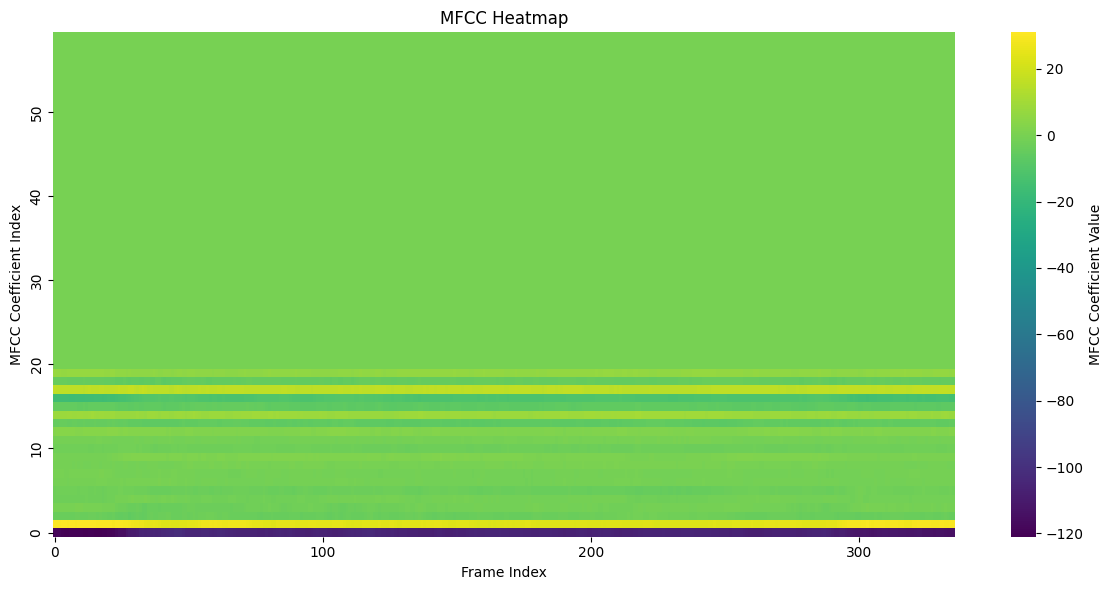

In [21]:
plot_mfcc_from_txt('/content/mfcc.txt')

In [23]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mfcc(
    input_path="black_woodpecker.wav",
    frame_len=2048,
    hop_length=128,
    num_coeffs=20,
    output_path="mfcc_python_plot.png"
):
    # ─── Load Audio ───────────────────────────────────────────────
    y, sr = librosa.load(input_path, sr=None, mono=True)
    print(f"Loaded '{input_path}' - duration: {len(y)/sr:.2f}s, sample rate: {sr}Hz")

    # ─── Compute MFCC ─────────────────────────────────────────────
    mfccs = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_fft=frame_len,
        hop_length=hop_length,
        n_mfcc=num_coeffs
    )  # shape: (n_mfcc, n_frames)
    print(f"MFCC shape: {mfccs.shape} (coefficients x frames)")

    # ─── Log Normalize (same as Rust ln_1p(abs(x))) ───────────────
    abs_log_mfcc = np.log1p(np.abs(mfccs))

    # ─── Percentile Clipping (1%–99%) ─────────────────────────────
    flat = abs_log_mfcc.flatten()
    p1 = np.percentile(flat, 1)
    p99 = np.percentile(flat, 99)
    clipped = np.clip(abs_log_mfcc, p1, p99)

    # ─── Normalize to 0–1 for VIRIDIS color ───────────────────────
    norm_mfcc = (clipped - p1) / (p99 - p1 + 1e-9)

    # ─── Plotting ─────────────────────────────────────────────────
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        norm_mfcc,
        cmap="viridis",
        cbar_kws={"label": "Log-MFCC Coefficient"},
        xticklabels=100,
        yticklabels=5,
        linewidths=0.0
    )
    plt.gca().invert_yaxis()  # to match Rust-style plot orientation
    plt.title("MFCC Heatmap")
    plt.xlabel("Frame Index")
    plt.ylabel("MFCC Coefficient Index")
    plt.tight_layout()

    # ─── Save ─────────────────────────────────────────────────────
    plt.savefig(output_path, dpi=300)
    plt.show()
    print(f"Saved heatmap to '{output_path}'")

# Run



Loaded '/content/black_woodpecker.wav' - duration: 1.02s, sample rate: 44000Hz
MFCC shape: (20, 352) (coefficients x frames)


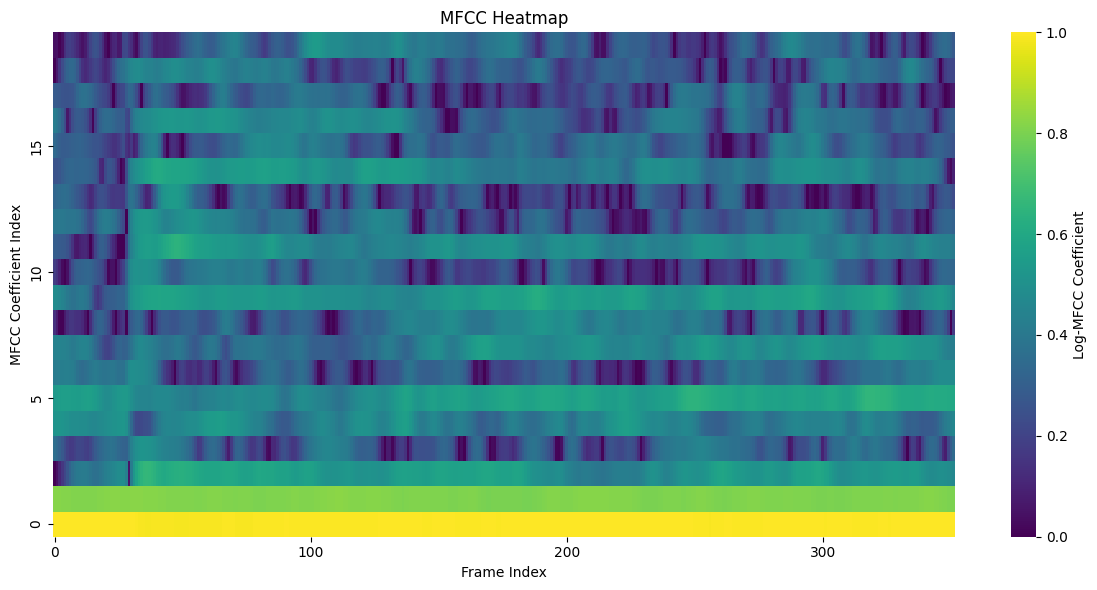

Saved heatmap to 'mfcc_python_plot.png'


In [24]:
plot_mfcc("/content/black_woodpecker.wav", frame_len=2048, hop_length=128, num_coeffs=20)